In [1]:
from google.colab import drive
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import math
import nltk
from nltk.tokenize import word_tokenize
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from textblob import TextBlob

#drive.mount('/content/drive')
nltk.download('punkt')

#ai_df = pd.read_csv("drive/MyDrive/AI_Human.csv")
ai_df = pd.read_csv("/content/AI_Human.csv")
ai_df = ai_df[:5000]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In the data above, 1 means AI generated and 0 means human generated.

In [2]:
feature_set = pd.DataFrame({})
feature_set["orig_str"] = ai_df['text']
feature_set["word_count"] = [len(x.split(" ")) for x in feature_set["orig_str"]]
feature_set

,orig_str,word_count
0,Cars. Cars have been around since they became ...,581
1,Transportation is a large necessity in most co...,458
2,"""America's love affair with it's vehicles seem...",740
3,How often do you ride in a car? Do you drive a...,684
4,Cars are a wonderful thing. They are perhaps o...,868
...,...,...
4995,Their's many other ways to go from one place t...,607
4996,"As our atmosphere constantly changes, so do ou...",598
4997,Limiting car use can be a good thing and a bad...,388
4998,"""People are generating a revolutionary change,...",322


In [3]:
def avg_sentence_length(text):
    sentences = sent_tokenize(text)
    total_length = sum(len(sentence.split()) for sentence in sentences)
    return total_length / len(sentences) if len(sentences) > 0 else 0

# Apply the function to create a new column
feature_set['avg_sentence_length'] = feature_set['orig_str'].apply(avg_sentence_length)

feature_set

,orig_str,word_count,avg_sentence_length
0,Cars. Cars have been around since they became ...,581,25.391304
1,Transportation is a large necessity in most co...,458,17.111111
2,"""America's love affair with it's vehicles seem...",740,15.500000
3,How often do you ride in a car? Do you drive a...,684,14.595745
4,Cars are a wonderful thing. They are perhaps o...,868,17.420000
...,...,...,...
4995,Their's many other ways to go from one place t...,607,19.125000
4996,"As our atmosphere constantly changes, so do ou...",598,17.705882
4997,Limiting car use can be a good thing and a bad...,388,26.200000
4998,"""People are generating a revolutionary change,...",322,21.600000


In [4]:
feature_set['label'] = ai_df['generated'].astype(int)
feature_set

,orig_str,word_count,avg_sentence_length,label
0,Cars. Cars have been around since they became ...,581,25.391304,0
1,Transportation is a large necessity in most co...,458,17.111111,0
2,"""America's love affair with it's vehicles seem...",740,15.500000,0
3,How often do you ride in a car? Do you drive a...,684,14.595745,0
4,Cars are a wonderful thing. They are perhaps o...,868,17.420000,0
...,...,...,...,...
4995,Their's many other ways to go from one place t...,607,19.125000,0
4996,"As our atmosphere constantly changes, so do ou...",598,17.705882,0
4997,Limiting car use can be a good thing and a bad...,388,26.200000,0
4998,"""People are generating a revolutionary change,...",322,21.600000,0


In [5]:
from nltk.lm import Laplace
feature_set = feature_set[0:250] #[0:5000]

# Tokenize the text into words
def tokenize_text(text):
    return list(map(str.lower, word_tokenize(text)))

# Train the language model with Laplace smoothing
def train_language_model(data):
    tokens = [tokenize_text(text) for text in data]
    n = 2  # You can adjust the order of the n-gram model
    train_data, padded_vocab = padded_everygram_pipeline(n, tokens)
    lm = Laplace(n)  # Use Laplace smoothing
    lm.fit(train_data, padded_vocab)
    return lm

# Function to calculate perplexity of a sentence
def calculate_perplexity(sentence, model):
    tokenized_sentence = tokenize_text(sentence)
    perplexity = model.perplexity(tokenized_sentence)
    return perplexity

# Train the language model using the text in the DataFrame column
lm = train_language_model(feature_set['orig_str'])

# Calculate perplexity for each sentence in the DataFrame column
feature_set['perplexity'] = feature_set['orig_str'].apply(calculate_perplexity, model=lm)

feature_set

<ipython-input-5-401df3bf48c0>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set['perplexity'] = feature_set['orig_str'].apply(calculate_perplexity, model=lm)


,orig_str,word_count,avg_sentence_length,label,perplexity
0,Cars. Cars have been around since they became ...,581,25.391304,0,3661.142391
1,Transportation is a large necessity in most co...,458,17.111111,0,3359.068337
2,"""America's love affair with it's vehicles seem...",740,15.500000,0,3659.376035
3,How often do you ride in a car? Do you drive a...,684,14.595745,0,3576.895201
4,Cars are a wonderful thing. They are perhaps o...,868,17.420000,0,3739.955858
...,...,...,...,...,...
245,"From riding horses with wagons to, driving car...",620,21.517241,0,4270.634480
246,"Dear senator, The Electoral College is unfair,...",382,17.545455,0,3782.198484
247,"Dear State Senator, I have realized that there...",616,23.846154,0,4426.349189
248,"Dear Mr.Mrs. Senator, In light of previous res...",478,26.722222,0,4006.423601


In [6]:
from textblob import TextBlob

# Calculate sentiment polarity
feature_set["sentiment_polarity"] = [TextBlob(text).sentiment.polarity for text in feature_set['orig_str']]

feature_set

<ipython-input-6-5e4b8a53d87c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set["sentiment_polarity"] = [TextBlob(text).sentiment.polarity for text in feature_set['orig_str']]


,orig_str,word_count,avg_sentence_length,label,perplexity,sentiment_polarity
0,Cars. Cars have been around since they became ...,581,25.391304,0,3661.142391,0.078961
1,Transportation is a large necessity in most co...,458,17.111111,0,3359.068337,0.040952
2,"""America's love affair with it's vehicles seem...",740,15.500000,0,3659.376035,0.107667
3,How often do you ride in a car? Do you drive a...,684,14.595745,0,3576.895201,0.063834
4,Cars are a wonderful thing. They are perhaps o...,868,17.420000,0,3739.955858,0.119379
...,...,...,...,...,...,...
245,"From riding horses with wagons to, driving car...",620,21.517241,0,4270.634480,0.078885
246,"Dear senator, The Electoral College is unfair,...",382,17.545455,0,3782.198484,0.192370
247,"Dear State Senator, I have realized that there...",616,23.846154,0,4426.349189,0.201209
248,"Dear Mr.Mrs. Senator, In light of previous res...",478,26.722222,0,4006.423601,0.217143


In [7]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string

# Download NLTK resources
nltk.download('stopwords')

# Function to count stop words and punctuation marks
def count_stopwords_and_punctuation(text):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    word_tokens = nltk.word_tokenize(text)

    # Count stop words
    stop_words_count = sum(1 for word in word_tokens if word.lower() in stop_words)

    # Count punctuation marks
    punctuation_count = sum(1 for char in text if char in punctuation)

    return stop_words_count, punctuation_count


# Apply the function to each row in the DataFrame
feature_set['stopwords_count'], feature_set['punctuation_count'] = zip(*feature_set['orig_str'].apply(count_stopwords_and_punctuation))

feature_set

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-7-5195605f2ac9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set['stopwords_count'], feature_set['punctuation_count'] = zip(*feature_set['orig_str'].apply(count_stopwords_and_punctuation))
<ipython-input-7-5195605f2ac9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set['stopwords_count'], feature_set['punctuation_count'] = zip(*feature_set['orig_str']

,orig_str,word_count,avg_sentence_length,label,perplexity,sentiment_polarity,stopwords_count,punctuation_count
0,Cars. Cars have been around since they became ...,581,25.391304,0,3661.142391,0.078961,264,75
1,Transportation is a large necessity in most co...,458,17.111111,0,3359.068337,0.040952,198,64
2,"""America's love affair with it's vehicles seem...",740,15.500000,0,3659.376035,0.107667,333,101
3,How often do you ride in a car? Do you drive a...,684,14.595745,0,3576.895201,0.063834,319,124
4,Cars are a wonderful thing. They are perhaps o...,868,17.420000,0,3739.955858,0.119379,393,110
...,...,...,...,...,...,...,...,...
245,"From riding horses with wagons to, driving car...",620,21.517241,0,4270.634480,0.078885,342,53
246,"Dear senator, The Electoral College is unfair,...",382,17.545455,0,3782.198484,0.192370,186,48
247,"Dear State Senator, I have realized that there...",616,23.846154,0,4426.349189,0.201209,327,48
248,"Dear Mr.Mrs. Senator, In light of previous res...",478,26.722222,0,4006.423601,0.217143,241,56


In [8]:
!pip install textstat
from textstat import flesch_reading_ease
from textstat import flesch_kincaid_grade

# Calculate Flesch Reading Ease
feature_set['flesch_reading_ease'] = feature_set['orig_str'].apply(flesch_reading_ease)
feature_set['flesch_kincaid_grade'] = feature_set['orig_str'].apply(flesch_kincaid_grade)

feature_set

<ipython-input-8-b61ff954cc7d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set['flesch_reading_ease'] = feature_set['orig_str'].apply(flesch_reading_ease)
<ipython-input-8-b61ff954cc7d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set['flesch_kincaid_grade'] = feature_set['orig_str'].apply(flesch_kincaid_grade)


,orig_str,word_count,avg_sentence_length,label,perplexity,sentiment_polarity,stopwords_count,punctuation_count,flesch_reading_ease,flesch_kincaid_grade
0,Cars. Cars have been around since they became ...,581,25.391304,0,3661.142391,0.078961,264,75,62.61,10.8
1,Transportation is a large necessity in most co...,458,17.111111,0,3359.068337,0.040952,198,64,62.58,8.8
2,"""America's love affair with it's vehicles seem...",740,15.500000,0,3659.376035,0.107667,333,101,55.74,9.3
3,How often do you ride in a car? Do you drive a...,684,14.595745,0,3576.895201,0.063834,319,124,65.73,7.6
4,Cars are a wonderful thing. They are perhaps o...,868,17.420000,0,3739.955858,0.119379,393,110,70.84,7.7
...,...,...,...,...,...,...,...,...,...,...
245,"From riding horses with wagons to, driving car...",620,21.517241,0,4270.634480,0.078885,342,53,75.03,8.1
246,"Dear senator, The Electoral College is unfair,...",382,17.545455,0,3782.198484,0.192370,186,48,62.17,8.9
247,"Dear State Senator, I have realized that there...",616,23.846154,0,4426.349189,0.201209,327,48,72.70,9.0
248,"Dear Mr.Mrs. Senator, In light of previous res...",478,26.722222,0,4006.423601,0.217143,241,56,52.83,12.5


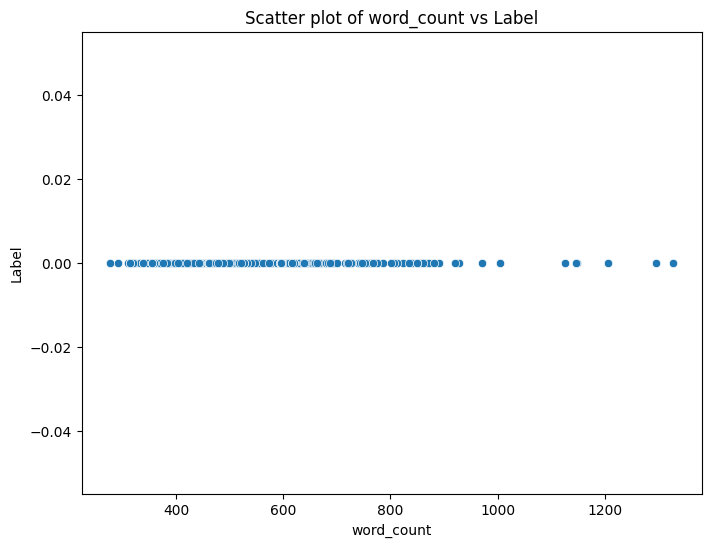

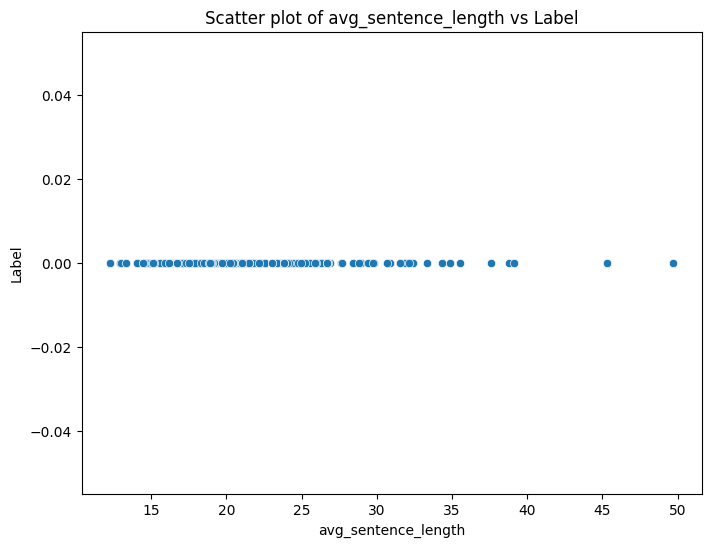

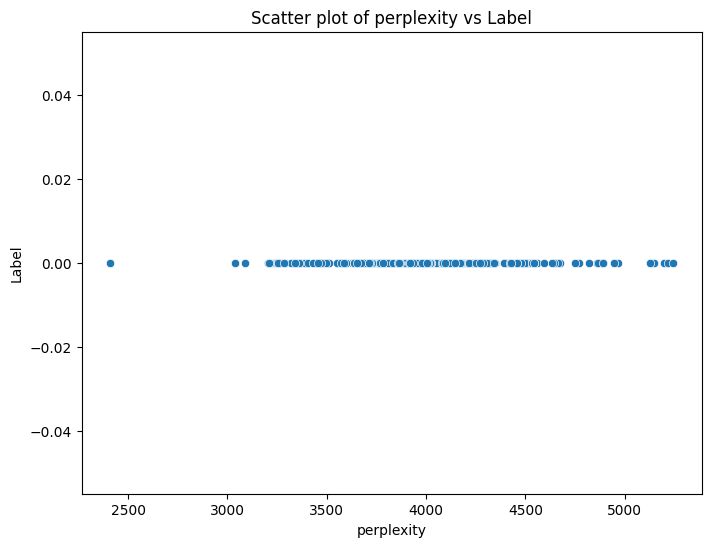

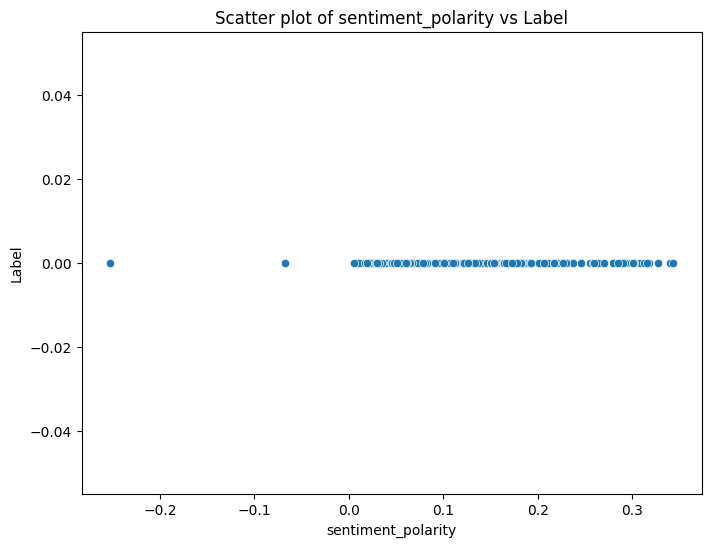

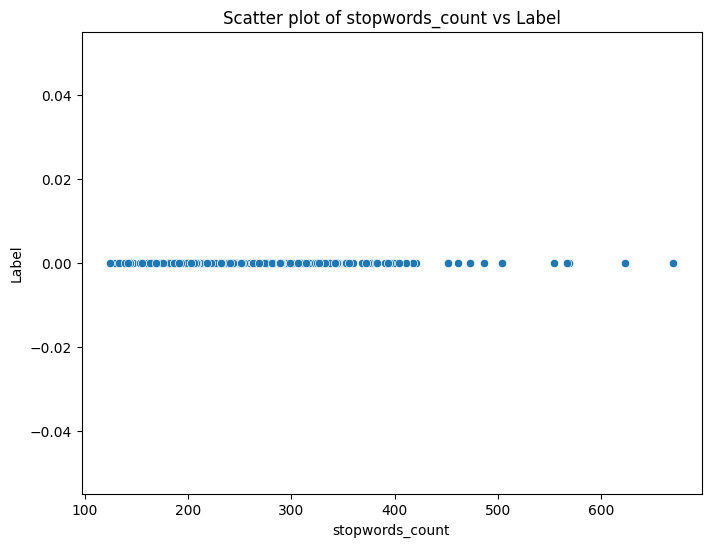

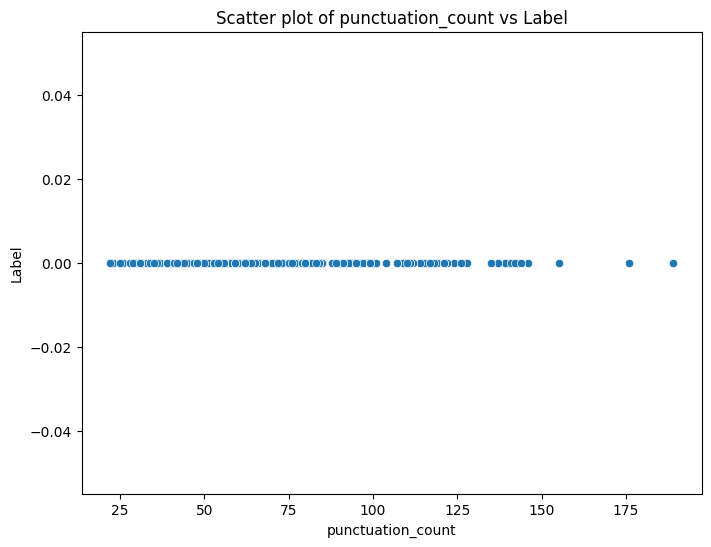

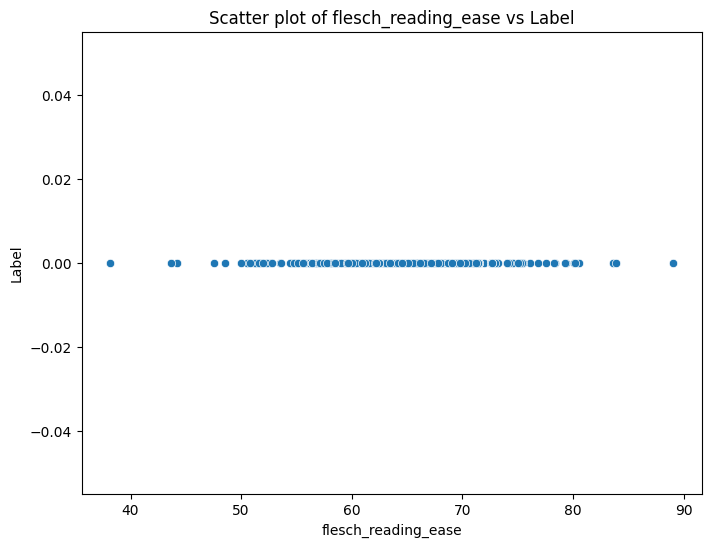

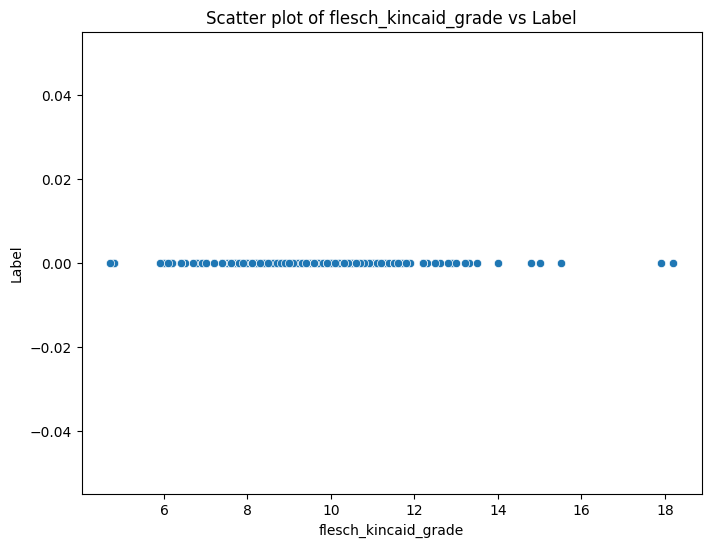

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Extract numeric columns (excluding label column)
numeric_columns = feature_set.select_dtypes(include='number').drop(columns=["label"], axis=1).columns

# Generate scatter plots for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=column, y='label', data=feature_set)
    plt.title(f'Scatter plot of {column} vs Label')
    plt.xlabel(column)
    plt.ylabel('Label')
    plt.show()

In [10]:
!pip install lmppl
import lmppl

scorer = lmppl.LM('gpt2')
scorer.get_perplexity(feature_set['orig_str'][1])

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:720: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/configuration_auto.py:1096: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:466: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


36.07451094145302

# Prep for Custom Model

In [11]:
import torch # machine learning framework
import torch.nn as nn # neural networks
import torch.nn.functional as F # neural network functions
from torch.utils.data import DataLoader # create DataLoaders
from torch.utils.data import Dataset # create Torch datasets
import torchtext # data processing utilities
from torchtext.data import get_tokenizer # tokenizer function
from torchtext.vocab import build_vocab_from_iterator # build vocabulary
from transformers import DistilBertConfig, DistilBertModel # DistilBERT

# set device for GPU/CPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# generate tokenizer function
tokenizer = get_tokenizer("basic_english")

In [12]:
# function to generate vocabulary from original strings
def yield_tokens(orig_strings):
    for str in orig_strings:
        yield tokenizer(str)

# build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(feature_set['orig_str']), specials=["<unk>"])

# define number of embeddings
num_embeddings = len(vocab)

# embedding dimensions
embedding_dim = 96

# DistilBERT

In [13]:
# initialize DistilBERT configuration
configuration = DistilBertConfig()

# initialize a DistilBERT model using configuration
model = DistilBertModel(configuration)

# review configuration
print('DistilBERT Config:\n', model.config)

DistilBERT Config:
 DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}



# Build Torch Datasets Class

In [14]:
# define class to build torch dataset required for pytorch training
class TorchDataset(Dataset):
    def __init__(self, texts, tokenizer, labels):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.labels = labels
        for text in texts:
            tokenized_text = tokenizer(text)
            self.input_ids.append([vocab[token] for token in tokenized_text])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        out = {
                'input_id': self.input_ids[idx],
                'label': self.labels.iloc[idx]
        }

        return out

# Build and Split Datasets

In [15]:
# first split dataset into 90% training and 10% testing, then
# split resulting training set into 80% training and 20% validation
train_and_val_size = round(len(feature_set) * 0.90)
train_size = round(train_and_val_size * 0.80)
val_size = train_and_val_size - train_size
test_size = len(feature_set) - train_and_val_size

# obtain indices for splitting
train_indices = list(range(train_size))
val_indices = list(range(train_size, train_and_val_size))
test_indices = list(range(train_and_val_size, train_and_val_size + test_size))

# call function to build torch datasets required for training
train_dataset = TorchDataset(feature_set['orig_str'].iloc[train_indices], tokenizer, feature_set['label'].iloc[train_indices])
val_dataset = TorchDataset(feature_set['orig_str'].iloc[val_indices], tokenizer, feature_set['label'].iloc[val_indices])
test_dataset = TorchDataset(feature_set['orig_str'].iloc[test_indices], tokenizer, feature_set['label'].iloc[test_indices])

# Create Dataloaders

In [16]:
# define custom collate_fn to zero-pad sequences
def collate_fn_padding(batch):

    # obtain input_ids and labels from batch, convert to torch tensors
    input_ids = [torch.tensor(sample['input_id']) for sample in batch]
    labels = torch.tensor([sample['label'] for sample in batch])

    # pad input sequences to maximum sequence length in batch
    max_length = max(len(input_id) for input_id in input_ids)
    padded_input_id = [F.pad(input=input_id, pad=(0, max_length - len(input_id)), mode='constant', value=0) for input_id in input_ids]

    # put the tensors together in a single batch
    padded_input_ids = torch.stack(padded_input_id)

    # convert labels to 2d float values for compatibility
    labels = labels.float()
    labels = labels.unsqueeze(1)

    return padded_input_ids, labels

In [17]:
# create dataloaders for train, val, and test datasets
# specify custom collate_fn
train_dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn_padding, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn_padding, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn_padding, shuffle=True)

In [18]:
# obtain inputs and labels of dataloader sample batches
train_inputs, train_labels = next(iter(train_dataloader))
val_inputs, val_labels = next(iter(val_dataloader))
test_inputs, test_labels = next(iter(test_dataloader))

# print sample batch inputs size
print('Sample Batch Inputs Size:')
print('-------------------------')
print('Train:', train_inputs.size())
print('Val:', val_inputs.size())
print('Test:', test_inputs.size())

# print sample batch labels size
print('\nSample Batch Labels Size:')
print('-------------------------')
print('Train:', train_labels.size())
print('Val:', val_labels.size())
print('Test:', test_labels.size())

Sample Batch Inputs Size:
-------------------------
Train: torch.Size([16, 810])
Val: torch.Size([16, 934])
Test: torch.Size([16, 995])

Sample Batch Labels Size:
-------------------------
Train: torch.Size([16, 1])
Val: torch.Size([16, 1])
Test: torch.Size([16, 1])


In [19]:
# define class to build custom transformer model
class TransformerModel(nn.Module):
    def __init__(
        self,
        num_embeddings, # size of vocab
        embedding_dim, # embedding dimensions
        d_model, # number of expected input features
        nhead, # number of heads for multi-attention
        dim_feedforward, # dimension of feedforward network
        dropout, # dropout value
        activation, # intermediate layer activation function
        num_layers # number of transformer layers
    ):
        super().__init__()

        # embedding layer
        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim)

        # transformer layers
        self.transformer_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model = d_model, # number of expected input features
                nhead = nhead, # number of heads for multi-attention
                dim_feedforward=dim_feedforward, # dimension of feedforward network
                dropout=dropout, # dropout value
                activation=activation # intermediate layer activation function
            ),
            num_layers=num_layers # number of transformer layers
        )

        # predictive layer, 1 output for binary classification
        self.predictive_layer = nn.Linear(embedding_dim, 1)

        # sigmoid activation function for output between 0 and 1
        self.sigmoid_activation = nn.Sigmoid()


    # function for forward pass
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.transformer_layers(x)
        x = torch.mean(x, dim=1) # mean pooling
        x = self.predictive_layer(x)
        x = self.sigmoid_activation(x)
        return x

In [20]:
# instantiate custom transformer model
custom_model = TransformerModel(
    num_embeddings, # size of vocab
    embedding_dim, # embedding dimensions
    d_model= 96, # number of expected input features
    nhead=12, # number of heads for multi-attention
    dim_feedforward=768, # dimension of feedforward network
    dropout=0.1, # dropout value
    activation='gelu', # intermediate layer activation function
    num_layers=6 # number of transformer layers
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [24]:
# define training function
def train(model, train_dataloader, val_dataloader, num_epochs=2, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):

        for inputs, labels in train_dataloader:

            # set to train mode
            model.train()

            # clear gradients
            optimizer.zero_grad()

            # forward pass, obtain predictions
            outputs = model(inputs)

            # calculate cross entropy loss
            loss = criterion(outputs, labels)

            # backward pass, backpropagation
            loss.backward()

            # model parameter update
            optimizer.step()

            # save running loss during training
            train_losses.append(loss.item())


        # set to eval mode
        model.eval()

        with torch.no_grad():

            for inputs, labels in val_dataloader:

                val_outputs = model(inputs)
                val_loss = criterion(val_outputs, labels)
                val_losses.append(val_loss.item())

            if epoch % 1 == 0:
                print(f'Epoch {epoch} -- train loss: {loss.item():.4f} -- val loss: {val_loss.item():.4f}')
    return train_losses, val_losses

In [25]:
# training parameters
num_epochs = 5 # number of epochs to train
lr = 0.001 # learning rate

# train model
train_losses, val_losses = train(custom_model, train_dataloader, val_dataloader, num_epochs=num_epochs, lr=lr)

Epoch 0 -- train loss: 0.0023 -- val loss: 0.0018
Epoch 1 -- train loss: 0.0011 -- val loss: 0.0009
Epoch 2 -- train loss: 0.0006 -- val loss: 0.0005
Epoch 3 -- train loss: 0.0004 -- val loss: 0.0004
Epoch 4 -- train loss: 0.0003 -- val loss: 0.0003


In [27]:
train_losses[:25]

[0.015107105486094952,
 0.007404237519949675,
 0.004863472655415535,
 0.004093221388757229,
 0.0038084047846496105,
 0.0036053198855370283,
 0.003386756172403693,
 0.003147919662296772,
 0.00290496414527297,
 0.002675613621249795,
 0.0024631728883832693,
 0.0022841915488243103,
 0.0021065659821033478,
 0.001958295702934265,
 0.0018275394104421139,
 0.0017089002067223191,
 0.0016028382815420628,
 0.0015083423350006342,
 0.0014221153687685728,
 0.0013429063837975264,
 0.0012698438949882984,
 0.0012030701618641615,
 0.001141520100645721,
 0.001087941462174058,
 0.0010295561514794827]

In [29]:
val_losses

[0.001843310077674687,
 0.0018433327786624432,
 0.001843328820541501,
 0.0008897546795196831,
 0.0008897538646124303,
 0.0008897529332898557,
 0.0005264811916276813,
 0.0005264808423817158,
 0.0005264814244583249,
 0.00035907019628211856,
 0.0003590700507629663,
 0.0003590694104786962,
 0.000268120871623978,
 0.0002681197947822511,
 0.00026812084252014756]